# Predicting Flight Delays

## Problem Statement
Is there any association with the airline and the delay in the state of Florida ?

## Hypotesis
- H0: There is no association between delay and airline in Florida
- H1: There is an association between the variables in the population

## Data Sources
The data used in this proyect is historical data from 2015 Flight Delays and Cancellations https://www.kaggle.com/datasets/usdot/flight-delays

## Choosing columns.


While keeping the problem statement in mind, we have selected the columns that will be used to find association between delay and airline. We added up all the delay types and put it in a new column called DELAYS

## 1. Getting the data

In [3]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

# models
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler

# performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# for ANOVA test
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [4]:
mylist = []

for chunk in  pd.read_csv('flights.csv', sep=',', chunksize=20000):
    mylist.append(chunk)

df_flights = pd.concat(mylist, axis= 0)
del mylist

In [5]:
df_airports = pd.read_csv('airports.csv')

# Exploratory Data Analysis (EDA)

In [6]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


here we have STATE and IATA_CODE

In [7]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


- We notice that we don't have the state in the dataframe "df_flights" and the delays are separated into different columns depending on the reason for the delay

- the  ORIGIN_AIRPORT in df_flights is the same code as the IATA_CODE in df_airports

## Add state in the dataframe df_flights

In [8]:
df_iata_code_state = df_airports[['IATA_CODE', 'STATE']]
df_flights = df_flights.join(df_iata_code_state.set_index('IATA_CODE'), on='ORIGIN_AIRPORT')


we use the IATA_CODE to join the data

In [9]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,STATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AK
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,CA
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,CA
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,CA
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,WA


Now the dataframe df_flights has STATE

## Flights filtered by Florida State

In [10]:
df_fl_flights = df_flights[df_flights['STATE'] == 'FL']

Since our hypothesis is based on the Florida flights, then we use only the Florida data.

In [11]:
df_fl_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,STATE
64,2015,1,1,4,AA,1323,N3CXAA,MCO,MIA,510,...,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
77,2015,1,1,4,EV,5583,N882AS,VPS,ATL,520,...,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
110,2015,1,1,4,EV,4160,N11150,JAX,EWR,540,...,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
144,2015,1,1,4,B6,2228,N231JB,MCO,EWR,550,...,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
153,2015,1,1,4,B6,860,N656JB,FLL,BDL,553,...,9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL


The dataframe df_fl_flights are only data from Florida

## Describing the data

In [12]:
df_fl_flights.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,415586.0,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,411142.000000,411142.000000,411029.000000,411029.000000,...,415586.000000,410705.000000,409611.000000,415586.000000,415586.000000,80338.000000,80338.000000,80338.000000,80338.000000,80338.000000
mean,2015.0,6.083321,15.704109,3.992353,1556.593242,1340.761412,1349.491254,10.961079,14.678903,1371.893981,...,1519.673841,1492.296427,5.572880,0.003318,0.011059,15.304401,0.104919,18.502527,25.386144,3.181135
std,0.0,3.472485,8.791170,2.002831,1141.071567,467.808764,485.118879,40.113820,6.921939,486.516164,...,500.329446,529.526736,42.027297,0.057508,0.104579,32.506344,2.700770,49.114804,46.503060,18.232280
min,2015.0,1.000000,1.000000,1.000000,1.000000,55.000000,1.000000,-46.000000,1.000000,1.000000,...,1.000000,1.000000,-66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,709.000000,930.000000,933.000000,-5.000000,11.000000,947.000000,...,1123.000000,1104.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,1355.000000,1335.000000,1343.000000,-2.000000,13.000000,1356.000000,...,1529.000000,1517.000000,-5.000000,0.000000,0.000000,2.000000,0.000000,3.000000,6.000000,0.000000
75%,2015.0,9.000000,23.000000,6.000000,2077.000000,1745.000000,1757.000000,9.000000,17.000000,1811.000000,...,1940.000000,1934.000000,8.000000,0.000000,0.000000,18.000000,0.000000,17.000000,31.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6898.000000,2359.000000,2400.000000,1536.000000,158.000000,2400.000000,...,2400.000000,2400.000000,1556.000000,1.000000,1.000000,784.000000,241.000000,1536.000000,1010.000000,932.000000


## Analize the datatype

In [13]:
# Using Pandas statistics to get general information about the clean data.
df_fl_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415586 entries, 64 to 5819077
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 415586 non-null  int64  
 1   MONTH                415586 non-null  int64  
 2   DAY                  415586 non-null  int64  
 3   DAY_OF_WEEK          415586 non-null  int64  
 4   AIRLINE              415586 non-null  object 
 5   FLIGHT_NUMBER        415586 non-null  int64  
 6   TAIL_NUMBER          414610 non-null  object 
 7   ORIGIN_AIRPORT       415586 non-null  object 
 8   DESTINATION_AIRPORT  415586 non-null  object 
 9   SCHEDULED_DEPARTURE  415586 non-null  int64  
 10  DEPARTURE_TIME       411142 non-null  float64
 11  DEPARTURE_DELAY      411142 non-null  float64
 12  TAXI_OUT             411029 non-null  float64
 13  WHEELS_OFF           411029 non-null  float64
 14  SCHEDULED_TIME       415582 non-null  float64
 15  ELAPSED_TIME   

we notice that all the delay features are Float64 and that there are some null values

### Check if there is null value in our data

In [14]:
df_fl_flights.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
FLIGHT_NUMBER               0
TAIL_NUMBER               976
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           4444
DEPARTURE_DELAY          4444
TAXI_OUT                 4557
WHEELS_OFF               4557
SCHEDULED_TIME              4
ELAPSED_TIME             5975
AIR_TIME                 5975
DISTANCE                    0
WHEELS_ON                4881
TAXI_IN                  4881
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME             4881
ARRIVAL_DELAY            5975
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON    410990
AIR_SYSTEM_DELAY       335248
SECURITY_DELAY         335248
AIRLINE_DELAY          335248
LATE_AIRCRAFT_DELAY    335248
WEATHER_DELAY          335248
STATE                       0
dtype: int64

### Replace all NaNs with 0

In [15]:
df_fl_flights = df_fl_flights.fillna(0)
df_fl_flights.isnull().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
STATE                  0
dtype: int64

now there is no null value in our data

In [16]:
df_fl_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415586 entries, 64 to 5819077
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 415586 non-null  int64  
 1   MONTH                415586 non-null  int64  
 2   DAY                  415586 non-null  int64  
 3   DAY_OF_WEEK          415586 non-null  int64  
 4   AIRLINE              415586 non-null  object 
 5   FLIGHT_NUMBER        415586 non-null  int64  
 6   TAIL_NUMBER          415586 non-null  object 
 7   ORIGIN_AIRPORT       415586 non-null  object 
 8   DESTINATION_AIRPORT  415586 non-null  object 
 9   SCHEDULED_DEPARTURE  415586 non-null  int64  
 10  DEPARTURE_TIME       415586 non-null  float64
 11  DEPARTURE_DELAY      415586 non-null  float64
 12  TAXI_OUT             415586 non-null  float64
 13  WHEELS_OFF           415586 non-null  float64
 14  SCHEDULED_TIME       415586 non-null  float64
 15  ELAPSED_TIME   

We saw that if drop all null values we will be left with no rows, so we fill all null values with 0

## Describing the data after we replace the null values with 0

In [17]:
df_fl_flights.describe(exclude = ['object'])

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,415586.0,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,...,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000
mean,2015.0,6.083321,15.704109,3.992353,1556.593242,1340.761412,1335.060693,10.843869,14.517946,1356.850835,...,1519.673841,1474.769612,5.492757,0.003318,0.011059,2.958533,0.020282,3.576771,4.907461,0.614953
std,0.0,3.472485,8.791170,2.002831,1141.071567,467.808764,502.085121,39.914692,7.051570,504.493682,...,500.329446,550.412018,41.729357,0.057508,0.104579,15.517404,1.188173,22.796983,22.771463,8.114040
min,2015.0,1.000000,1.000000,1.000000,1.000000,55.000000,0.000000,-46.000000,0.000000,0.000000,...,1.000000,0.000000,-66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,709.000000,930.000000,926.000000,-5.000000,11.000000,939.000000,...,1123.000000,1053.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,1355.000000,1335.000000,1338.000000,-2.000000,13.000000,1350.000000,...,1529.000000,1511.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015.0,9.000000,23.000000,6.000000,2077.000000,1745.000000,1755.000000,9.000000,17.000000,1809.000000,...,1940.000000,1930.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6898.000000,2359.000000,2400.000000,1536.000000,158.000000,2400.000000,...,2400.000000,2400.000000,1556.000000,1.000000,1.000000,784.000000,241.000000,1536.000000,1010.000000,932.000000


## Create new column DELAY

Our dependet variable is Delay, overall delay, so we will add all the delays and create a new column

In [18]:
sum_delay= ['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_fl_flights['DELAY'] = df_fl_flights[sum_delay].sum(axis=1)

## Describing the data based on the delay per airline

In [19]:
df_fl_flights[['AIRLINE', 'DELAY']].groupby(['AIRLINE']).describe()

DELAY                                                       
           count       mean         std   min   25%   50%   75%     max
AIRLINE                                                                
AA       83320.0  29.647480  125.377889 -67.0 -17.0  -6.0  21.0  4648.0
AS        1320.0  16.384091   86.411880 -66.0 -22.0  -6.0  17.0  1029.0
B6       56189.0  42.029739  124.089239 -69.0 -16.0  -3.0  37.0  1813.0
DL       73662.0  18.927385  125.554176 -67.0 -19.0 -11.0   4.0  3837.0
EV       10853.0  32.238828  131.181316 -79.0 -18.0  -7.0  14.0  2435.0
F9       10974.0  59.011573  171.079428 -77.0 -17.0   0.0  62.0  2385.0
MQ        9400.0  24.819681  102.433790 -58.0 -17.0  -7.0  11.0  1414.0
NK       21209.0  42.915838  122.485496 -58.0 -14.0  -1.0  42.0  2502.0
OO         590.0  54.442373  131.751860 -65.0 -12.0   2.0  58.0   959.0
UA       30400.0  27.626612  119.487785 -66.0 -20.0  -7.0  15.0  3143.0
US       18219.0  14.281958   85.321331 -69.0 -16.0  -7.0   6.0  2259.0
VX        1574.0  18.624524  101.766299 -63.0 -20.0  -6.0  13.0  1561.0
WN       97876.0  23.075647   97.857257 -71.0 -17.0  -7.0  13.0  1660.0

At first we could notice that all airlines have diferents means of delay

### Boxplot

We use boxplot to see more graphically the data distribution

<AxesSubplot:title={'center':'DELAY'}, xlabel='AIRLINE'>

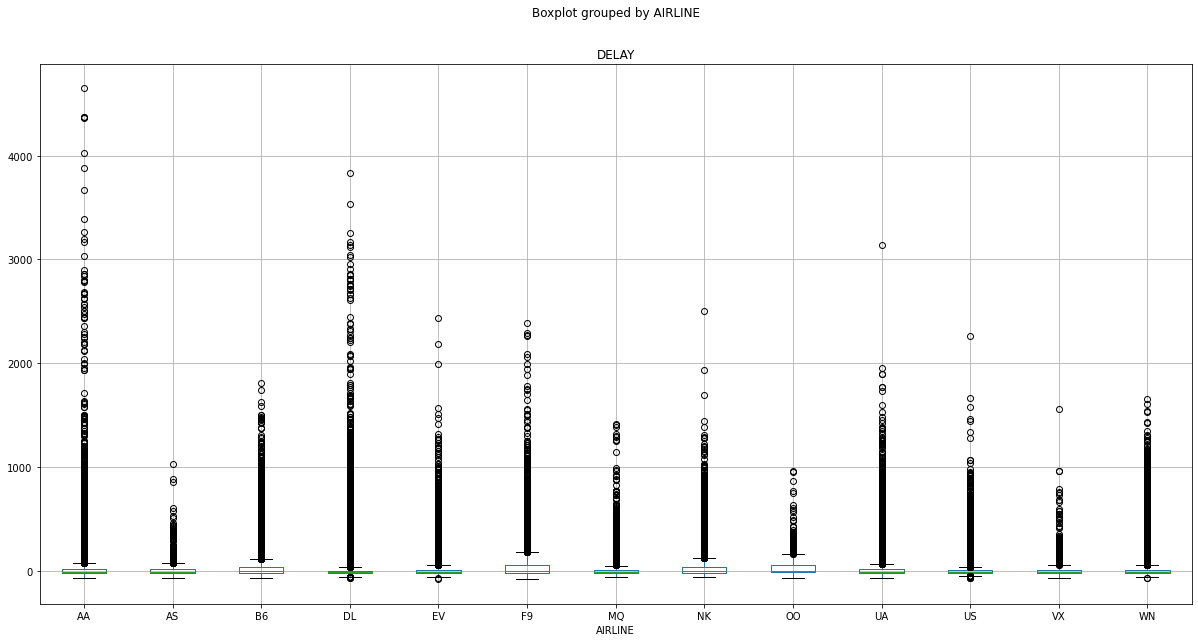

In [20]:
df_fl_flights.boxplot(column='DELAY', by='AIRLINE', figsize=(20, 10))

We notice that we have outliners in all airlines

### Shape with outliners

In [21]:
df_fl_flights.shape

(415586, 33)

### Removing outliers with the IQR method

In [22]:
#extracting all the delays per airline
airlines_codes = df_fl_flights['AIRLINE'].unique()
delays_airlines = []
for x in airlines_codes:
    delays_airlines.append(df_fl_flights[df_fl_flights['AIRLINE'] == x]['DELAY'])

In [23]:
#Finding Q1 y Q3 for each airline
# IQR
for i in range(0, len(delays_airlines)):
    Q1 = delays_airlines[i].quantile(0.25)
    Q3 = delays_airlines[i].quantile(0.75)

    IQR = Q3 - Q1

    # Upper bound
    upper = np.where(delays_airlines[i] >= (Q3+1.5*IQR))
    # Lower bound
    lower = np.where(delays_airlines[i] <= (Q1-1.5*IQR))
    
    #REMOVING OUTLIERS
    #df_fl_flights = df_fl_flights.drop((upper[0]).index)
    #df_fl_flights = df_fl_flights.drop((lower[0]).index)
#
    fence_low  = (Q1-1.5*IQR)
    fence_high = (Q3+1.5*IQR)

    df_fl_flights = df_fl_flights.drop(delays_airlines[i].loc[(delays_airlines[i] < fence_low) | (delays_airlines[i] > fence_high)].index)

now we have the dataframe df_fl_flights without outliners

### Shape without outliers

In [24]:
df_fl_flights.shape

(357662, 33)

Now we have 357662 rows instead of 415586

### Normality Assumption Check


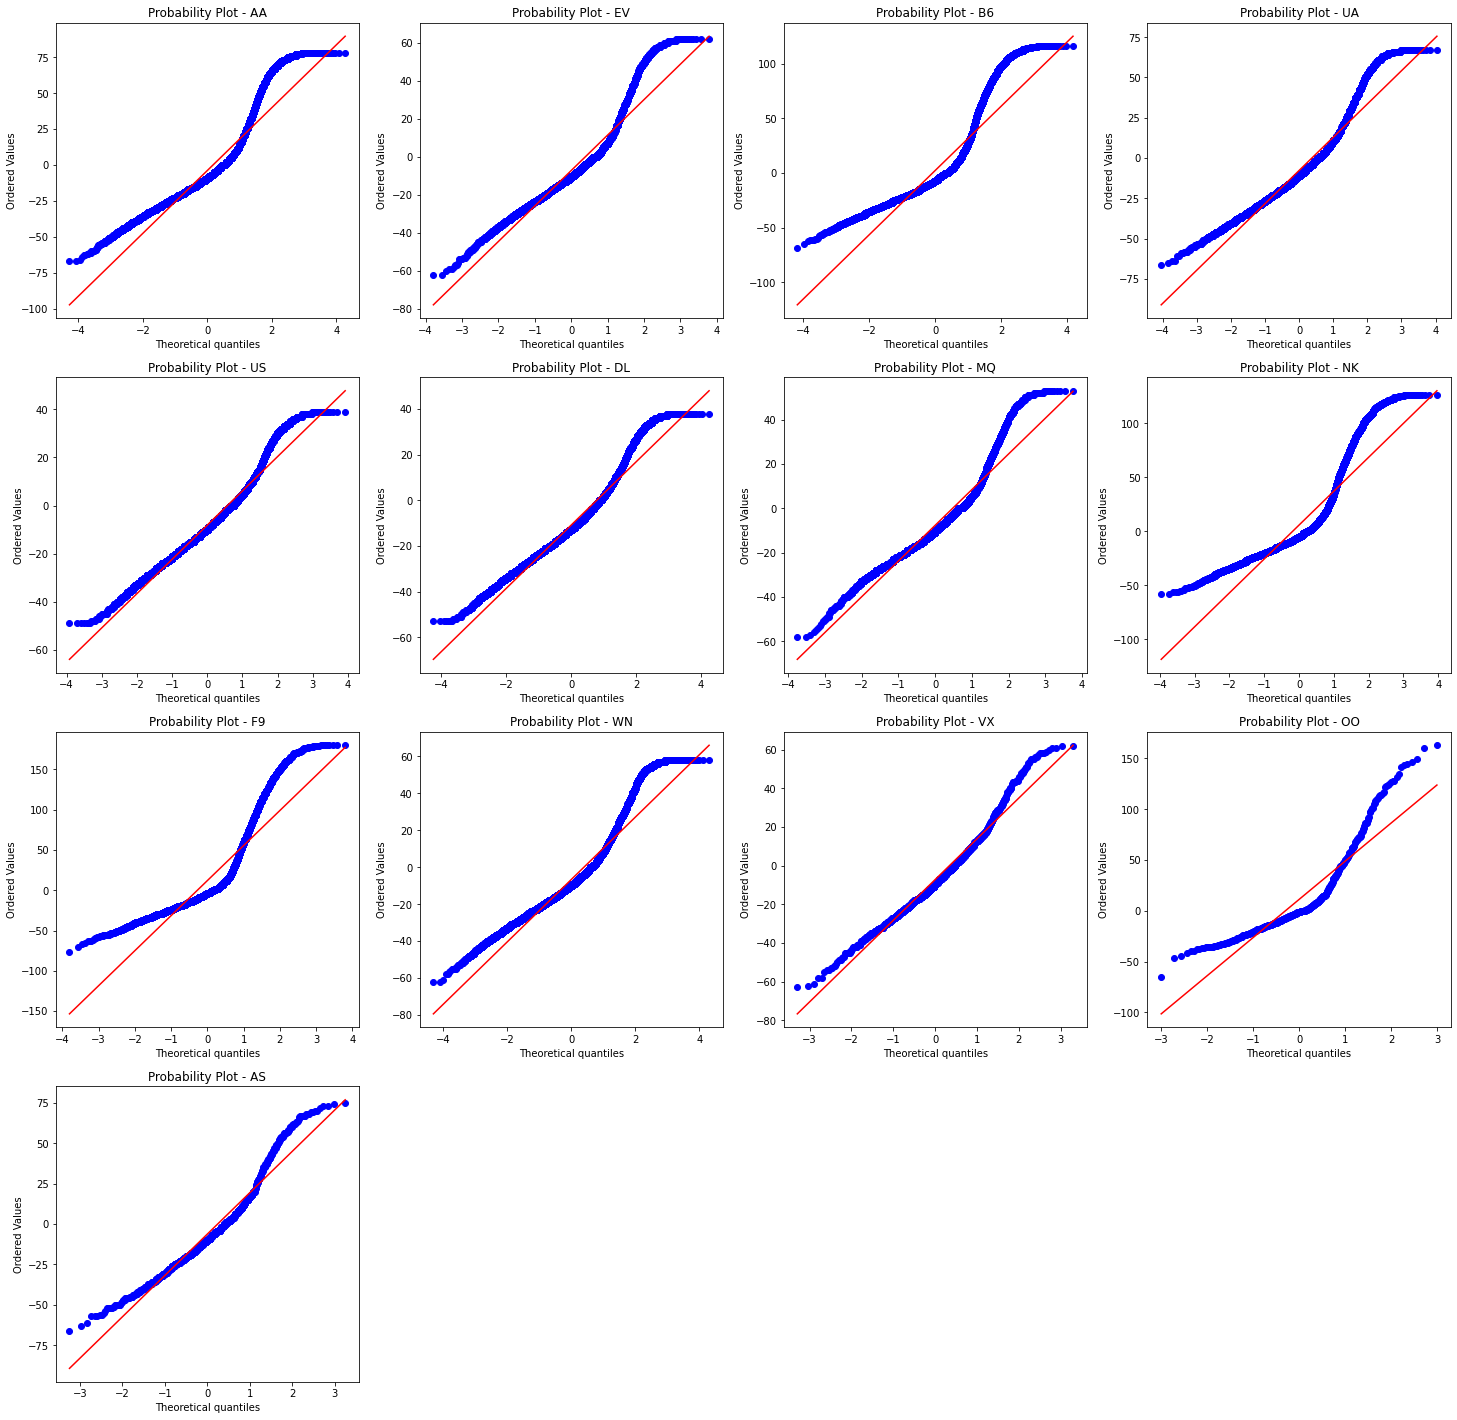

In [25]:
f, ax = plt.subplots(4, 4, figsize=(25, 25))
f.delaxes(ax[3,3])
f.delaxes(ax[3,2])
f.delaxes(ax[3,1])
unique_airline = df_fl_flights['AIRLINE'].unique()
i=0
j=0
for airline in unique_airline:
    stats.probplot(df_fl_flights[df_fl_flights['AIRLINE'] == airline]['DELAY'], dist="norm", plot=ax[j,i])
    ax[j,i].set_title("Probability Plot - " +  airline)
    i+=1
    if i == 4:
        i=0
        j+=1
plt.show()

The Q-Q plot shows a largely straight-line pattern if it is from a normal distribution. From the above figure, we may assume that the data for each group falls roughly on a straight line.

# We perfom ANOVA test

In [26]:
mod = ols('DELAY ~ AIRLINE', data=df_fl_flights).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df            F  PR(>F)
AIRLINE   1.056481e+07      12.0  1616.183165     0.0
Residual  1.948260e+08  357649.0          NaN     NaN


In [27]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_fl_flights['DELAY'].mean()
SSTR = df_fl_flights.groupby('AIRLINE').count() * (df_fl_flights.groupby('AIRLINE').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['DELAY'].sum()

# calculate SSE and update anova table
SSE = (df_fl_flights.groupby('AIRLINE').count() - 1) * df_fl_flights.groupby('AIRLINE').std()**2
anova_table['SS']['Within Groups'] = SSE['DELAY'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['DELAY'].sum() + SSE['DELAY'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_fl_flights['AIRLINE'].nunique() - 1
anova_table['df']['Within Groups'] = df_fl_flights.shape[0] - df_fl_flights['AIRLINE'].nunique()
anova_table['df']['Total'] = df_fl_flights.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types right-tailed, left-tailed, two-tailed
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,10564812.18035,12,880401.015029,1616.183165,0.0,1.944758
Within Groups,194826025.619776,357649,544.740865,,,
Total,205390837.800126,357661,574.261208,,,


In [28]:
# p-value approach
print("The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'],  "and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

The p-value approach to hypothesis testing in the decision rule
F-score is: 1616.1831645567354 and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.


We conclude that the null hypothesis is rejected, so we cannot affirm say that there is no association between delay and airline in Florida